In [1]:
import json
import datetime,time
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from statistics import mean
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statistics import mean
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

In [2]:
path = "tweet_data/"

files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", \
        "tweets_#nfl.txt", "tweets_#patriots.txt", \
        "tweets_#sb49.txt", "tweets_#superbowl.txt"]
topics = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]
test_files_1 =["sample0_period1.txt","sample0_period2.txt","sample0_period3.txt"]
test_files_2 =["sample1_period1.txt","sample1_period2.txt","sample1_period3.txt"]
test_files_3 =["sample2_period1.txt","sample2_period2.txt","sample2_period3.txt"]

for i, fl in enumerate(files):
    print("files[" + str(i) + "] => " + fl)

files[0] => tweets_#gohawks.txt
files[1] => tweets_#gopatriots.txt
files[2] => tweets_#nfl.txt
files[3] => tweets_#patriots.txt
files[4] => tweets_#sb49.txt
files[5] => tweets_#superbowl.txt


In [3]:
def generate_df(pddata_raw):
    """
    Create a new dataframe with desired form
    """
    df = pd.DataFrame([],columns=['time unit','tweets','retweets','followers sum','followers max','hr_min'])
    
    col = pddata_raw.columns.get_loc('time')
    df['time unit'] = range(int(pddata_raw.iloc[len(pddata_raw.index)-1,col] - pddata_raw.iloc[0,col]+1))
    df['tweets'] = pddata_raw.groupby("time")['tweets'].sum()
    df['retweets'] = pddata_raw.groupby("time")['retweets'].sum()
    df['followers sum'] = pddata_raw.groupby("time")['followers'].sum()
    df['followers max'] = pddata_raw.groupby("time")["followers"].max()
    df['hr_min'] = pddata_raw.groupby("time")['hr_min'].mean()        
    # reset index of df
    df = df.fillna(0).reset_index(drop=True)
    
    return df

In [4]:

def parse(path,files):
    """
    Parse x conponent of the dataset into pandas DataFrame including columns of:
    tweets, retweets, total_followers, max_followers, mentioned, media, active, author, favourites_count, title
    with lines of hours,
    where mentioned: number of @ in tweets per hour
          media: number of url in tweets per hour
          active: a measure of active state of author
          author: number of unique authors post tweet per hour
          favourites_count: the total number of likes by this user
          title: length of this tweet's title
    Parse y of dataset as number of tweets in the next hour.
    """
    start_time = time.mktime(time.strptime("2015-02-01 08:00:00",'%Y-%m-%d %H:%M:%S'))
    end_time = time.mktime(time.strptime("2015-02-01 20:00:00",'%Y-%m-%d %H:%M:%S'))   

    start_hour_idx = ((2-1)*31+1-14)*24+8
    end_hour_idx = ((2-1)*31+1-14)*24+20
    start_minute_idx = (((2-1)*31+1-14)*24 + (8-0))*12 + 0//5    
        
    # extract raw features
    data_raw = [[],[],[]]
    for file in files:
        for line in open(path + file, 'r', encoding="utf-8") :
            row_tmp = []
            a = json.loads(line)
            citation_date = a['citation_date']
            tweet = 1
            retweet = a['metrics']['citations']['total']
            foll = a['author']['followers']
            hr_min=1

            # append to row_tmp
            row_tmp.append(citation_date)        
            row_tmp.append(tweet)        
            row_tmp.append(retweet)
            row_tmp.append(foll)  
            row_tmp.append(hr_min) 
            
            data_raw[0].append(row_tmp)            

    # generate raw pandas dataframe
    pddata_raw_1 = transfer_time(data_raw[0],'hour')
    pddata_raw_1['time'] = pddata_raw_1['time'] - pddata_raw_1.loc[0,'time']
    
    
    # generate df and df_y for each time slot
    df_1 = generate_df(pddata_raw_1)  
    df_y_1 = df_1.iloc[1:,2].reset_index(drop=True)
    df_1 = df_1[:len(df_y_1)]
    #print('2',df_1)
    
    
    return (df_1.iloc[:,1:],df_y_1)

In [5]:
def transfer_time(data_raw,time_type):
    
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    # sort according to time
    pddata_raw = pd.DataFrame(data_raw,columns=['time','tweets','retweets','followers','hr_min'])
    pddata_raw = pddata_raw.sort_values(by = 'time')
    pddata_raw = pddata_raw.reset_index(drop=True)               

    # calculate hour index and minute index from time
    if time_type == 'hour':
        hour_accu = []
        hour_min = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)  
            hour_accu.append(((p.month-1)*31+p.day)*24+p.hour)  
            hour_min.append(p.hour)
        pddata_raw['time'] = hour_accu
        pddata_raw['hr_min'] = hour_min
    elif time_type == 'minute':
        minu_accu = []
        hour_min = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)                    
            minu_accu.append((((p.month-1)*31+p.day)*24 + (p.hour-0))*12 + p.minute//5)   
            hour_min.append(p.minute//5)
        pddata_raw['time'] = minu_accu    
        pddata_raw['hr_min'] = hour_min
    else:
        print("Invalid time type")
        
    return pddata_raw

In [6]:
def plot_recipe(df_y, pred_y):
    """
    This function plots fitted values vs true values
    """
    plt.figure()
    area = np.pi * (4)**2/4
    plt.scatter(df_y, pred_y, s = area)
    plt.plot([df_y.min(), df_y.max()], [df_y.min(), df_y.max()], 'k--', lw = 1)
    plt.xlabel('true values')
    plt.ylabel('fitted values')
    plt.show()

In [8]:
df,df_y =parse(path,files)

In [14]:
df_test1,df_y_test1 = parse(path,test_files_1)
df_test2,df_y_test2= parse(path,test_files_2)
df_test3,df_y_test3= parse(path,test_files_3)

NameError: name 'parse_dataset' is not defined

In [9]:
param_grid={
'max_depth': [10, 20, 50, 100],
'max_features': ['auto', 'sqrt'],
'min_samples_leaf': [1, 2, 4],
'min_samples_split': [2, 5, 10],
'n_estimators': [5,10,50,100,200, 400, 600, 800]
}
kf = KFold(n_splits=5,random_state=42,shuffle=True)

In [10]:
avg_RMSE1_train=np.zeros((4,2,3,3,8))
avg_RMSE1_test=np.zeros((4,2,3,3,8))
for n1,max_depth in enumerate(param_grid['max_depth']):
    for n2,max_features in enumerate(param_grid['max_features']):
        for n3,min_samples_leaf in enumerate(param_grid['min_samples_leaf']):
            for n4,min_samples_split in enumerate(param_grid['min_samples_split']):
                for n5,n_estimators in enumerate(param_grid['n_estimators']):
                    MSE_train=[]
                    MSE_test=[]
                    oob_error=[]
                    total_train=0
                    total_test=0
                    for train_index, test_index in kf.split(df):
                        X_train= df.iloc[train_index]
                        y_train= df_y.iloc[train_index]
                        X_test= df.iloc[test_index]
                        y_test= df_y.iloc[test_index]
                        reg = GradientBoostingRegressor(n_estimators=n_estimators,max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split, max_features=max_features,random_state=42)
                        reg.fit(X_train,y_train)
                        pred_train = reg.predict(X_train)
                        pred_test = reg.predict(X_test)
                        MSE_train.append(mean_squared_error(y_train, pred_train)*len(train_index))
                        MSE_test.append(mean_squared_error(y_test, pred_test)*len(test_index))
                        total_train=total_train+len(train_index)
                        total_test=total_test+len(test_index)

                    avg_RMSE1_test[n1,n2,n3,n4,n5]=np.sqrt(sum(MSE_test)/total_test)
                    avg_RMSE1_train[n1,n2,n3,n4,n5]=np.sqrt(sum(MSE_train)/total_train)
                    print("max_depth=",max_depth,"max_features=",max_features,"min_samples_leaf=",min_samples_leaf,"min_samples_split=",min_samples_split,"n_estimators=",n_estimators)
                    print("RMSE_train=",avg_RMSE1_train[n1,n2,n3,n4,n5],"RMSE_test=",avg_RMSE1_test[n1,n2,n3,n4,n5])
                    print("")

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimators= 5
RMSE_train= 39033.58335895909 RMSE_test= 52374.777362095134

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimators= 10
RMSE_train= 23053.993200111552 RMSE_test= 52612.888958007265

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimators= 50
RMSE_train= 380.80648970281646 RMSE_test= 66157.26037751016

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimators= 100
RMSE_train= 43.646602424940575 RMSE_test= 66438.35106296485

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimators= 200
RMSE_train= 2.0614851419184785 RMSE_test= 66439.36478727942

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimators= 400
RMSE_train= 0.008905675379541213 RMSE_test= 66439.36575120542

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimat

max_depth= 10 max_features= auto min_samples_leaf= 4 min_samples_split= 2 n_estimators= 600
RMSE_train= 1000.3765712734025 RMSE_test= 57997.40733131372

max_depth= 10 max_features= auto min_samples_leaf= 4 min_samples_split= 2 n_estimators= 800
RMSE_train= 456.2108645417439 RMSE_test= 57798.391364715775

max_depth= 10 max_features= auto min_samples_leaf= 4 min_samples_split= 5 n_estimators= 5
RMSE_train= 45607.469665362725 RMSE_test= 50916.71029711839

max_depth= 10 max_features= auto min_samples_leaf= 4 min_samples_split= 5 n_estimators= 10
RMSE_train= 35486.11117440421 RMSE_test= 45941.944824958555

max_depth= 10 max_features= auto min_samples_leaf= 4 min_samples_split= 5 n_estimators= 50
RMSE_train= 17921.123877391612 RMSE_test= 50751.865817735095

max_depth= 10 max_features= auto min_samples_leaf= 4 min_samples_split= 5 n_estimators= 100
RMSE_train= 12596.039173320913 RMSE_test= 55266.8075693539

max_depth= 10 max_features= auto min_samples_leaf= 4 min_samples_split= 5 n_estimators

max_depth= 10 max_features= sqrt min_samples_leaf= 2 min_samples_split= 5 n_estimators= 200
RMSE_train= 1433.223356012414 RMSE_test= 50876.783157462356

max_depth= 10 max_features= sqrt min_samples_leaf= 2 min_samples_split= 5 n_estimators= 400
RMSE_train= 168.79997002864272 RMSE_test= 51980.848991665815

max_depth= 10 max_features= sqrt min_samples_leaf= 2 min_samples_split= 5 n_estimators= 600
RMSE_train= 21.951895784163593 RMSE_test= 52118.537272205635

max_depth= 10 max_features= sqrt min_samples_leaf= 2 min_samples_split= 5 n_estimators= 800
RMSE_train= 2.6569947317226315 RMSE_test= 52135.68920989397

max_depth= 10 max_features= sqrt min_samples_leaf= 2 min_samples_split= 10 n_estimators= 5
RMSE_train= 44506.3577485083 RMSE_test= 50488.38651775008

max_depth= 10 max_features= sqrt min_samples_leaf= 2 min_samples_split= 10 n_estimators= 10
RMSE_train= 33192.52206232863 RMSE_test= 44480.95344056265

max_depth= 10 max_features= sqrt min_samples_leaf= 2 min_samples_split= 10 n_estimat

max_depth= 20 max_features= auto min_samples_leaf= 1 min_samples_split= 10 n_estimators= 50
RMSE_train= 2222.415119282566 RMSE_test= 50880.72754484991

max_depth= 20 max_features= auto min_samples_leaf= 1 min_samples_split= 10 n_estimators= 100
RMSE_train= 157.6889696879717 RMSE_test= 51321.934825909164

max_depth= 20 max_features= auto min_samples_leaf= 1 min_samples_split= 10 n_estimators= 200
RMSE_train= 3.6012181097891474 RMSE_test= 51386.04491294643

max_depth= 20 max_features= auto min_samples_leaf= 1 min_samples_split= 10 n_estimators= 400
RMSE_train= 0.01430066567901662 RMSE_test= 51386.645163591806

max_depth= 20 max_features= auto min_samples_leaf= 1 min_samples_split= 10 n_estimators= 600
RMSE_train= 0.00031454730567619365 RMSE_test= 51386.64542822914

max_depth= 20 max_features= auto min_samples_leaf= 1 min_samples_split= 10 n_estimators= 800
RMSE_train= 0.0003145473056771519 RMSE_test= 51386.64542822914

max_depth= 20 max_features= auto min_samples_leaf= 2 min_samples_spli

max_depth= 20 max_features= sqrt min_samples_leaf= 1 min_samples_split= 2 n_estimators= 50
RMSE_train= 340.6440942431722 RMSE_test= 51078.7283346539

max_depth= 20 max_features= sqrt min_samples_leaf= 1 min_samples_split= 2 n_estimators= 100
RMSE_train= 1.7556090130280981 RMSE_test= 51258.209300067276

max_depth= 20 max_features= sqrt min_samples_leaf= 1 min_samples_split= 2 n_estimators= 200
RMSE_train= 0.0003153034897698221 RMSE_test= 51259.11931855461

max_depth= 20 max_features= sqrt min_samples_leaf= 1 min_samples_split= 2 n_estimators= 400
RMSE_train= 0.00031530348973837454 RMSE_test= 51259.11931855461

max_depth= 20 max_features= sqrt min_samples_leaf= 1 min_samples_split= 2 n_estimators= 600
RMSE_train= 0.0003153034897272723 RMSE_test= 51259.11931855461

max_depth= 20 max_features= sqrt min_samples_leaf= 1 min_samples_split= 2 n_estimators= 800
RMSE_train= 0.0003153034897238656 RMSE_test= 51259.11931855461

max_depth= 20 max_features= sqrt min_samples_leaf= 1 min_samples_split=

max_depth= 20 max_features= sqrt min_samples_leaf= 4 min_samples_split= 5 n_estimators= 50
RMSE_train= 19210.28325418396 RMSE_test= 49258.12043940074

max_depth= 20 max_features= sqrt min_samples_leaf= 4 min_samples_split= 5 n_estimators= 100
RMSE_train= 13411.824987342583 RMSE_test= 51998.1912553913

max_depth= 20 max_features= sqrt min_samples_leaf= 4 min_samples_split= 5 n_estimators= 200
RMSE_train= 7989.842715059574 RMSE_test= 56679.58694241938

max_depth= 20 max_features= sqrt min_samples_leaf= 4 min_samples_split= 5 n_estimators= 400
RMSE_train= 3339.814617030821 RMSE_test= 59028.260876043554

max_depth= 20 max_features= sqrt min_samples_leaf= 4 min_samples_split= 5 n_estimators= 600
RMSE_train= 1484.2212950291764 RMSE_test= 59204.73020165027

max_depth= 20 max_features= sqrt min_samples_leaf= 4 min_samples_split= 5 n_estimators= 800
RMSE_train= 660.2709909456898 RMSE_test= 59283.88946936412

max_depth= 20 max_features= sqrt min_samples_leaf= 4 min_samples_split= 10 n_estimators

max_depth= 50 max_features= auto min_samples_leaf= 2 min_samples_split= 10 n_estimators= 50
RMSE_train= 9448.676033176902 RMSE_test= 52411.71661146433

max_depth= 50 max_features= auto min_samples_leaf= 2 min_samples_split= 10 n_estimators= 100
RMSE_train= 3420.9499494946376 RMSE_test= 56420.13320035813

max_depth= 50 max_features= auto min_samples_leaf= 2 min_samples_split= 10 n_estimators= 200
RMSE_train= 625.7429359809864 RMSE_test= 58750.56652918009

max_depth= 50 max_features= auto min_samples_leaf= 2 min_samples_split= 10 n_estimators= 400
RMSE_train= 31.791660843419464 RMSE_test= 59223.987493972425

max_depth= 50 max_features= auto min_samples_leaf= 2 min_samples_split= 10 n_estimators= 600
RMSE_train= 2.44713376568257 RMSE_test= 59239.712880261955

max_depth= 50 max_features= auto min_samples_leaf= 2 min_samples_split= 10 n_estimators= 800
RMSE_train= 0.31188250366587306 RMSE_test= 59240.51635585424

max_depth= 50 max_features= auto min_samples_leaf= 4 min_samples_split= 2 n_es

max_depth= 50 max_features= sqrt min_samples_leaf= 2 min_samples_split= 2 n_estimators= 50
RMSE_train= 7081.217447213403 RMSE_test= 47869.80416855129

max_depth= 50 max_features= sqrt min_samples_leaf= 2 min_samples_split= 2 n_estimators= 100
RMSE_train= 3446.3336992869376 RMSE_test= 49848.136060455996

max_depth= 50 max_features= sqrt min_samples_leaf= 2 min_samples_split= 2 n_estimators= 200
RMSE_train= 1044.7387960725896 RMSE_test= 51696.386527217095

max_depth= 50 max_features= sqrt min_samples_leaf= 2 min_samples_split= 2 n_estimators= 400
RMSE_train= 124.63290651896865 RMSE_test= 52545.259349990476

max_depth= 50 max_features= sqrt min_samples_leaf= 2 min_samples_split= 2 n_estimators= 600
RMSE_train= 15.432224612128225 RMSE_test= 52657.00317941235

max_depth= 50 max_features= sqrt min_samples_leaf= 2 min_samples_split= 2 n_estimators= 800
RMSE_train= 1.63646893803963 RMSE_test= 52670.30725012181

max_depth= 50 max_features= sqrt min_samples_leaf= 2 min_samples_split= 5 n_estimat

RMSE_train= 29210.54170461034 RMSE_test= 42629.33291144892

max_depth= 100 max_features= auto min_samples_leaf= 1 min_samples_split= 5 n_estimators= 50
RMSE_train= 1296.5504240312482 RMSE_test= 48240.95931143869

max_depth= 100 max_features= auto min_samples_leaf= 1 min_samples_split= 5 n_estimators= 100
RMSE_train= 18.322225846179855 RMSE_test= 48599.05885003415

max_depth= 100 max_features= auto min_samples_leaf= 1 min_samples_split= 5 n_estimators= 200
RMSE_train= 0.00478824954137549 RMSE_test= 48605.2029848143

max_depth= 100 max_features= auto min_samples_leaf= 1 min_samples_split= 5 n_estimators= 400
RMSE_train= 0.00031406222913296655 RMSE_test= 48605.20251975052

max_depth= 100 max_features= auto min_samples_leaf= 1 min_samples_split= 5 n_estimators= 600
RMSE_train= 0.0003140622291311692 RMSE_test= 48605.20251975052

max_depth= 100 max_features= auto min_samples_leaf= 1 min_samples_split= 5 n_estimators= 800
RMSE_train= 0.0003140622291300168 RMSE_test= 48605.20251975052

max_dep

max_depth= 100 max_features= auto min_samples_leaf= 4 min_samples_split= 5 n_estimators= 800
RMSE_train= 450.525089105559 RMSE_test= 57664.735505048884

max_depth= 100 max_features= auto min_samples_leaf= 4 min_samples_split= 10 n_estimators= 5
RMSE_train= 45611.51294344624 RMSE_test= 50909.23191925923

max_depth= 100 max_features= auto min_samples_leaf= 4 min_samples_split= 10 n_estimators= 10
RMSE_train= 35758.589185824196 RMSE_test= 46026.61173121596

max_depth= 100 max_features= auto min_samples_leaf= 4 min_samples_split= 10 n_estimators= 50
RMSE_train= 21535.171205393246 RMSE_test= 50635.925992911325

max_depth= 100 max_features= auto min_samples_leaf= 4 min_samples_split= 10 n_estimators= 100
RMSE_train= 15715.702083378936 RMSE_test= 56202.30635565774

max_depth= 100 max_features= auto min_samples_leaf= 4 min_samples_split= 10 n_estimators= 200
RMSE_train= 8328.103244687636 RMSE_test= 59847.49446733961

max_depth= 100 max_features= auto min_samples_leaf= 4 min_samples_split= 10 n

max_depth= 100 max_features= sqrt min_samples_leaf= 2 min_samples_split= 10 n_estimators= 400
RMSE_train= 551.632697062267 RMSE_test= 51910.37407337278

max_depth= 100 max_features= sqrt min_samples_leaf= 2 min_samples_split= 10 n_estimators= 600
RMSE_train= 112.28670451649486 RMSE_test= 52072.40227732972

max_depth= 100 max_features= sqrt min_samples_leaf= 2 min_samples_split= 10 n_estimators= 800
RMSE_train= 22.201275815865195 RMSE_test= 52090.54364673916

max_depth= 100 max_features= sqrt min_samples_leaf= 4 min_samples_split= 2 n_estimators= 5
RMSE_train= 47256.8520889915 RMSE_test= 52333.95677796691

max_depth= 100 max_features= sqrt min_samples_leaf= 4 min_samples_split= 2 n_estimators= 10
RMSE_train= 36579.09877565789 RMSE_test= 45961.25468878903

max_depth= 100 max_features= sqrt min_samples_leaf= 4 min_samples_split= 2 n_estimators= 50
RMSE_train= 18568.762808549207 RMSE_test= 49277.060435319596

max_depth= 100 max_features= sqrt min_samples_leaf= 4 min_samples_split= 2 n_esti

In [11]:
print("min RMSE in testset=",np.min(avg_RMSE1_test))
print("parameters:")
n1,n2,n3,n4,n5= np.unravel_index(np.argmin(avg_RMSE1_test), avg_RMSE1_test.shape)
print("max_depth=",param_grid["max_depth"][n1],"max_features=",param_grid["max_features"][n2],"min_samples_leaf=",param_grid["min_samples_leaf"][n3],"min_samples_split=",param_grid["min_samples_split"][n4],"n_estimators=",param_grid["n_estimators"][n5])
print("")

min RMSE in testset= 39944.557972131566
parameters:
max_depth= 50 max_features= auto min_samples_leaf= 2 min_samples_split= 2 n_estimators= 10



In [12]:
reg = GradientBoostingRegressor(n_estimators=param_grid["n_estimators"][n5],max_depth=param_grid["max_depth"][n1],min_samples_leaf=param_grid["min_samples_leaf"][n3],min_samples_split=param_grid["min_samples_split"][n4], max_features=param_grid["max_features"][n2],random_state=42)
reg.fit(df,df_y)
pred = reg.predict(df)
print("MSE=",mean_squared_error(df_y, pred))

MSE= 758978450.1592393


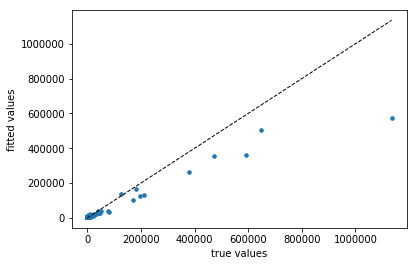

In [13]:
plot_recipe(df_y, pred)

In [16]:
hidden_units=[50,100,200,300,500,600]

In [20]:
avg_RMSE2_train=np.zeros((len(hidden_units),len(hidden_units),len(hidden_units)))
avg_RMSE2_test=np.zeros((len(hidden_units),len(hidden_units),len(hidden_units)))
for n1,units1 in enumerate(hidden_units):
    for n2,units2 in enumerate(hidden_units):
        for n3,units3 in enumerate(hidden_units):
            MSE_train=[]
            MSE_test=[]
            total_train=0
            total_test=0
            for train_index, test_index in kf.split(df):
                X_train= df.iloc[train_index]
                y_train= df_y.iloc[train_index]
                X_test= df.iloc[test_index]
                y_test= df_y.iloc[test_index]
                reg = MLPRegressor(hidden_layer_sizes=(units1,units2,units3,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 
                reg.fit(X_train,y_train)
                pred_train = reg.predict(X_train)
                pred_test = reg.predict(X_test)
                MSE_train.append(mean_squared_error(y_train, pred_train)*len(train_index))
                MSE_test.append(mean_squared_error(y_test, pred_test)*len(test_index))
                total_train=total_train+len(train_index)
                total_test=total_test+len(test_index)

            avg_RMSE2_test[n1,n2,n3]=np.sqrt(sum(MSE_test)/total_test)
            avg_RMSE2_train[n1,n2,n3]=np.sqrt(sum(MSE_train)/total_train)
            print("units1=",units1,"units2=",units2,"units3=",units3)
            print("RMSE_train=",avg_RMSE2_train[n1,n2,n3],"RMSE_test=",avg_RMSE2_test[n1,n2,n3])
            print("")

units1= 50 units2= 50 units3= 50
RMSE_train= 151379.8363576873 RMSE_test= 134652.89462087158

units1= 50 units2= 50 units3= 100
RMSE_train= 980296.8740774316 RMSE_test= 1125794.2096049967

units1= 50 units2= 50 units3= 200
RMSE_train= 626981.8824369335 RMSE_test= 610348.2247523089

units1= 50 units2= 50 units3= 300
RMSE_train= 1178941.9263749286 RMSE_test= 1216438.5701891256

units1= 50 units2= 50 units3= 500
RMSE_train= 46499.43693104577 RMSE_test= 71119.00394751669

units1= 50 units2= 50 units3= 600
RMSE_train= 109784.37756398732 RMSE_test= 115621.06126025341

units1= 50 units2= 100 units3= 50
RMSE_train= 167137.41882871333 RMSE_test= 179865.4860792854

units1= 50 units2= 100 units3= 100
RMSE_train= 531445.0644536656 RMSE_test= 517088.2985820079

units1= 50 units2= 100 units3= 200
RMSE_train= 1951114.4452658978 RMSE_test= 1707305.8482276483

units1= 50 units2= 100 units3= 300
RMSE_train= 98334.31213634984 RMSE_test= 137042.6578391064

units1= 50 units2= 100 units3= 500
RMSE_train= 28

units1= 200 units2= 200 units3= 200
RMSE_train= 438541.78835573635 RMSE_test= 387984.5889920148

units1= 200 units2= 200 units3= 300
RMSE_train= 82358.12011073768 RMSE_test= 92887.38676381604

units1= 200 units2= 200 units3= 500
RMSE_train= 115874.02300246709 RMSE_test= 93975.49905673043

units1= 200 units2= 200 units3= 600
RMSE_train= 39832.19402410606 RMSE_test= 40362.34241955189

units1= 200 units2= 300 units3= 50
RMSE_train= 280585.33541176043 RMSE_test= 297134.6482447669

units1= 200 units2= 300 units3= 100
RMSE_train= 368468.0902391561 RMSE_test= 323192.6224653351

units1= 200 units2= 300 units3= 200
RMSE_train= 705559.8172192387 RMSE_test= 749091.7559884099

units1= 200 units2= 300 units3= 300
RMSE_train= 316822.8145272028 RMSE_test= 357512.83565659623

units1= 200 units2= 300 units3= 500
RMSE_train= 54383.42847882991 RMSE_test= 88248.77362325668

units1= 200 units2= 300 units3= 600
RMSE_train= 40145.56735766724 RMSE_test= 62213.96988994033

units1= 200 units2= 500 units3= 50
RM

units1= 500 units2= 500 units3= 500
RMSE_train= 99572.18952102074 RMSE_test= 34658.62675088035

units1= 500 units2= 500 units3= 600
RMSE_train= 102318.24941120623 RMSE_test= 119751.12257440902

units1= 500 units2= 600 units3= 50
RMSE_train= 51581.67093748891 RMSE_test= 51269.898995408075

units1= 500 units2= 600 units3= 100
RMSE_train= 277497.1783061402 RMSE_test= 311515.1351786983

units1= 500 units2= 600 units3= 200
RMSE_train= 140160.8367826997 RMSE_test= 150583.56572427342

units1= 500 units2= 600 units3= 300
RMSE_train= 954831.5283251838 RMSE_test= 1497403.030678596

units1= 500 units2= 600 units3= 500
RMSE_train= 46072.51665415654 RMSE_test= 53635.6271700721

units1= 500 units2= 600 units3= 600
RMSE_train= 63060.74800293675 RMSE_test= 38198.2826702298

units1= 600 units2= 50 units3= 50
RMSE_train= 118730.41830739356 RMSE_test= 100000.10130724705

units1= 600 units2= 50 units3= 100
RMSE_train= 344239.3678739176 RMSE_test= 116974.47193354079

units1= 600 units2= 50 units3= 200
RMSE

In [21]:
print("min RMSE in testset=",np.min(avg_RMSE2_test))
n1,n2,n3= np.unravel_index(np.argmin(avg_RMSE2_test), avg_RMSE2_test.shape)
print("hidden layer sizes=",hidden_units[n1],hidden_units[n2],hidden_units[n3])

min RMSE in testset= 34658.62675088035
hidden layer sizes= 500 500 500


In [22]:
reg = MLPRegressor(hidden_layer_sizes=(hidden_units[n1],hidden_units[n2],hidden_units[n3],),activation='relu', solver='adam', alpha=1e-5, random_state=42) 
reg.fit(df,df_y)
pred = reg.predict(df)
print("MSE=",mean_squared_error(df_y, pred))

MSE= 1938963562.5349042


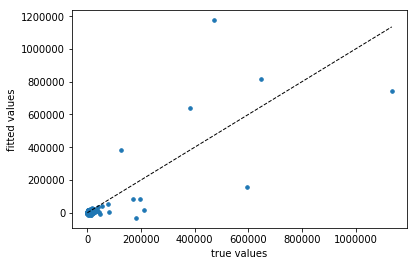

In [23]:
plot_recipe(df_y, pred)